In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('air_pollution_data.csv')

In [3]:
df

,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,Ahmedabad,03-12-2020,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,Ahmedabad,04-12-2020,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53
...,...,...,...,...,...,...,...,...,...,...,...
23499,Visakhapatnam,21-05-2023,3,353.81,0.00,2.08,100.14,4.11,37.53,47.09,0.08
23500,Visakhapatnam,22-05-2023,3,380.52,0.00,3.77,82.97,5.07,32.17,43.44,1.74
23501,Visakhapatnam,23-05-2023,3,390.53,0.00,4.28,80.11,5.19,36.01,48.06,1.20
23502,Visakhapatnam,24-05-2023,3,300.41,0.00,1.36,95.84,2.21,30.17,48.89,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     23504 non-null  float64
 6   o3      23504 non-null  float64
 7   so2     23504 non-null  float64
 8   pm2_5   23504 non-null  float64
 9   pm10    23504 non-null  float64
 10  nh3     23504 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [5]:
df.describe()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,23504.000000,23504.000000,23504.00000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000
mean,3.920354,1113.224543,6.00554,25.044104,35.059777,15.971449,98.598310,121.848091,12.060212
std,1.415490,1401.770372,24.50272,25.839242,31.901760,23.943464,135.572391,160.429589,17.544759
min,1.000000,173.570000,0.00000,0.310000,0.000000,0.190000,0.500000,0.580000,0.000000
25%,3.000000,447.270000,0.00000,8.740000,7.870000,4.470000,24.677500,32.277500,2.340000
50%,5.000000,700.950000,0.00000,16.450000,28.250000,7.990000,58.860000,75.775000,6.520000
75%,5.000000,1188.280000,0.27000,32.220000,54.360000,16.450000,117.605000,147.642500,15.830000
max,5.000000,23071.290000,457.76000,331.760000,406.270000,442.510000,2203.550000,2429.130000,352.620000


In [6]:
df.isnull().sum()

city     0
date     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['date'])


C:\Users\Ankit Sharma\AppData\Local\Temp\ipykernel_18156\584440916.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [9]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

### Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

df_numeric = df.select_dtypes(include=['number'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

### Model Development

In [18]:
# Sort by date (important for time series)
df = df.sort_values(by='date')

df_prophet = df.rename(columns={'date': 'ds', 'aqi': 'y'}) 

In [19]:
# Let's use 80% of the data for training
split_index = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]

In [20]:
train_df = df_prophet.iloc[:int(len(df_prophet) * 0.8)]
model = Prophet()
model.fit(train_df)

15:07:35 - cmdstanpy - INFO - Chain [1] start processing
15:07:38 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Forecast into the future for the same length as test set
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Make predictions
forecast = model.predict(future)

### Model Evalution

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecast_test = forecast[['ds', 'yhat']].iloc[-len(test_df):]
comparison = test_df[['ds', 'y']].merge(forecast_test, on='ds')

# Calculate metrics
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
r2 = r2_score(comparison['y'], comparison['yhat'])

print(f"Meam Absolute Error:  {mae:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"R squared:   {r2:.4f}")

Meam Absolute Error:  0.60
Root Mean Square Error: 0.72
R squared:   -0.0420


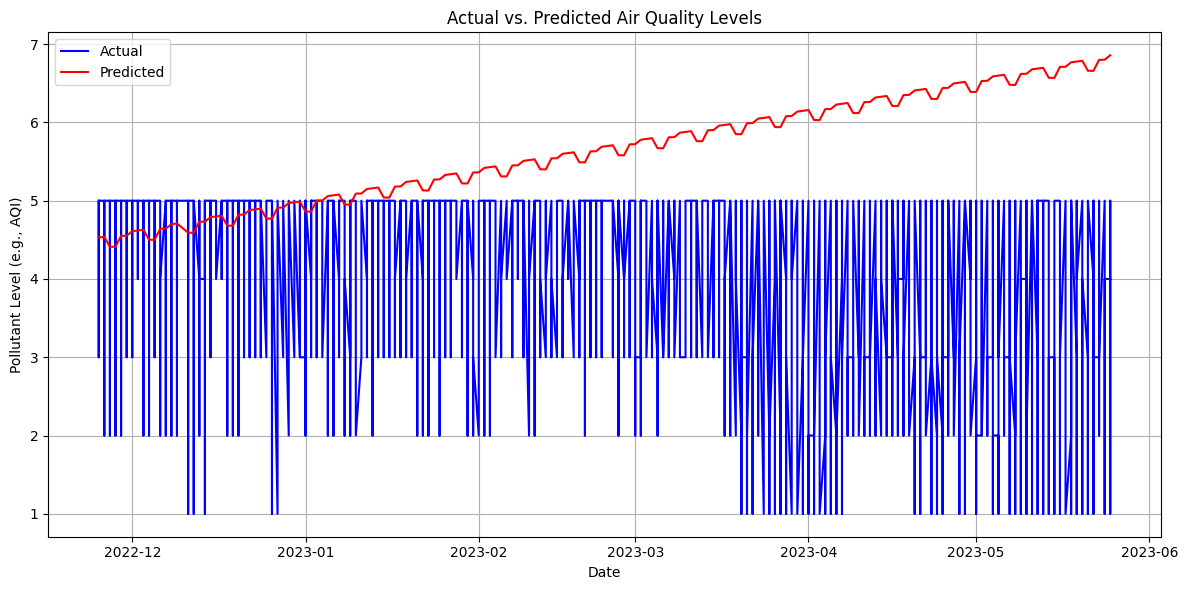

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual', color='blue')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red')
plt.title('Actual vs. Predicted Air Quality Levels')
plt.xlabel('Date')
plt.ylabel('Pollutant Level (e.g., AQI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

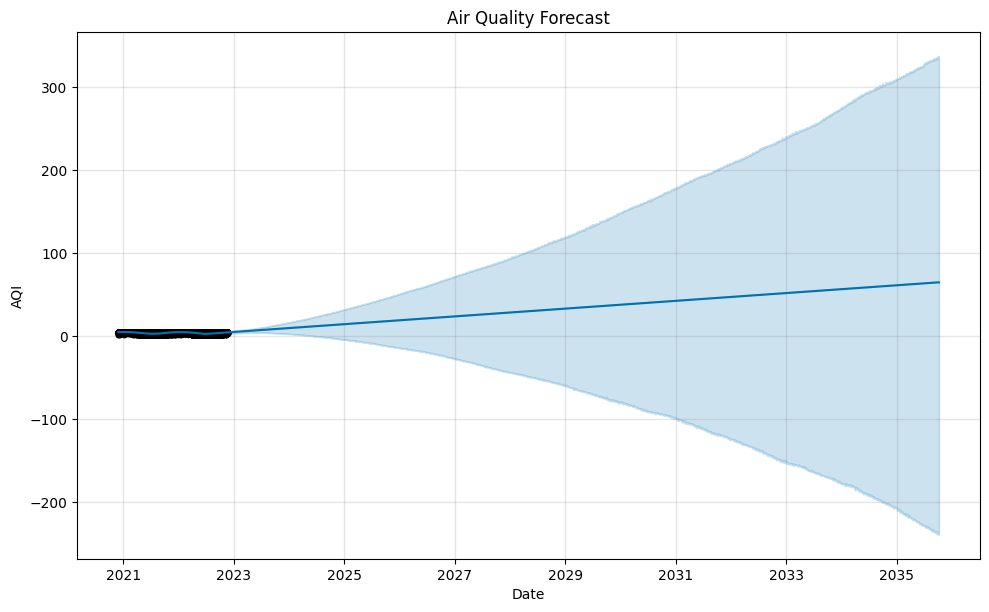

In [22]:
import matplotlib.pyplot as plt

# Plot forecast
model.plot(forecast)
plt.title("Air Quality Forecast")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

### Predicting one week air quality

In [30]:
# Rename columns for Prophet compatibility
df = df.rename(columns={'date': 'ds', 'aqi': 'y'})
df['ds'] = pd.to_datetime(df['ds'])  # Ensure datetime format

In [31]:
# Initialize and train model
model = Prophet()
model.fit(df)

# Forecast into the future
future = model.make_future_dataframe(periods=7)  # predict 7 days ahead
forecast = model.predict(future)

# Filter to only future forecasts
forecast_future = forecast[forecast['ds'] > df['ds'].max()]

# Display
print(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

15:33:30 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
904 2023-05-26  3.016925    1.401913    4.528071
905 2023-05-27  3.006697    1.530306    4.754797
906 2023-05-28  2.847174    1.222977    4.562808
907 2023-05-29  2.813665    1.268506    4.296647
908 2023-05-30  2.915302    1.481899    4.619029
909 2023-05-31  2.889626    1.275840    4.371576
910 2023-06-01  2.902663    1.337408    4.581685


### LSTM for comparision

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Prepare your feature and target (assuming df is preprocessed and has 'ds' and 'y')
data = df[['y']].values  # shape: (n_samples, 1)

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert to supervised sequence data
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(data_scaled, window_size)

# Reshape to [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define input dimensions
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

C:\Users\Ankit Sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1171 - val_loss: 0.0624
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1078 - val_loss: 0.0627
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1052 - val_loss: 0.0653
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1033 - val_loss: 0.0623
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1060 - val_loss: 0.0628
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1052 - val_loss: 0.0618
Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1053 - val_loss: 0.0617
Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1041 - val_loss: 0.0649
Epoch 9/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1031 - val_loss: 0.0633
Epoch 10/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1056 - val_loss: 0.0644
Epoch 11/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1046 - val_loss: 0.0624
Epoch 12/20
1175/1175 ━━━━━━